# Discord Chat Text Analysis

Analysing the Discord Chat #progress, 66DaysOfData

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

import json
import os

%matplotlib inline

In [3]:
os.listdir()

['.ipynb_checkpoints',
 '66DaysofData - important - progress [749516705734197258].json',
 'progressDiscordChatAnalysis.ipynb']

In [25]:
filename = '66DaysofData - important - progress [749516705734197258].json' # 20/09/2020 NZT time of download of this file

with open(filename, 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data=data, record_path='messages')

In [15]:
df.shape

(1705, 15)

In [16]:
df.head()

,id,type,timestamp,timestampEdited,callEndedTimestamp,isPinned,content,attachments,embeds,reactions,author.id,author.name,author.discriminator,author.isBot,author.avatarUrl
0,749937010868748351,Default,2020-08-31T10:21:56.547+00:00,None,None,False,Day1: Created a GitHub repo. Created an R and ...,[],[],"[{'emoji': {'id': None, 'name': '💯', 'isAnimat...",715593892438736898,William Guesdon,3961,False,https://cdn.discordapp.com/embed/avatars/1.png
1,750045262277378089,Default,2020-08-31T17:32:05.694+00:00,None,None,False,> Day1: Created a GitHub repo. Created an R an...,[],[],"[{'emoji': {'id': None, 'name': '👍', 'isAnimat...",743513993250996376,Andrew from DataLeap,8501,False,https://cdn.discordapp.com/avatars/74351399325...
2,750067004639281224,Default,2020-08-31T18:58:29.477+00:00,None,None,False,Thank you @Andrew from DataLeap It can definit...,[],[],[],715593892438736898,William Guesdon,3961,False,https://cdn.discordapp.com/embed/avatars/1.png
3,750068015126544485,Default,2020-08-31T19:02:30.396+00:00,None,None,False,"Guys i am a beginner , would appreciate if you...",[],[],[],750065427107020843,vc,3696,False,https://cdn.discordapp.com/embed/avatars/1.png
4,750070203576221857,Default,2020-08-31T19:11:12.163+00:00,None,None,False,"Hi Guys, Started with basic Stat",[],[],[],750069445883461713,Arth,1001,False,https://cdn.discordapp.com/embed/avatars/1.png


In [17]:
df.dtypes

id                      object
type                    object
timestamp               object
timestampEdited         object
callEndedTimestamp      object
isPinned                  bool
content                 object
attachments             object
embeds                  object
reactions               object
author.id               object
author.name             object
author.discriminator    object
author.isBot              bool
author.avatarUrl        object
dtype: object

In [35]:
# most commented peole
df['author.name'].value_counts().head(10)

MEE6                142
dsgeek101            47
Ashley.bee           32
Wilson               25
15Daniel             25
Aaron Petry          24
Niven                24
RLChibi              23
nedal                22
_dominiquejames_     22
Name: author.name, dtype: int64

In [85]:
df['timestamp_reformated'] = df['timestamp'].astype('datetime64[ns]')

# adding a count
for i in range(len(df)):
    df.iloc[i]['counter'] = i + 1
df.head()

C:\Users\Shiva\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,type,timestamp,timestampEdited,callEndedTimestamp,isPinned,content,attachments,embeds,reactions,author.id,author.name,author.discriminator,author.isBot,author.avatarUrl,timestamp_reformated,counter
0,749937010868748351,Default,2020-08-31T10:21:56.547+00:00,None,None,False,Day1: Created a GitHub repo. Created an R and ...,[],[],"[{'emoji': {'id': None, 'name': '💯', 'isAnimat...",715593892438736898,William Guesdon,3961,False,https://cdn.discordapp.com/embed/avatars/1.png,2020-08-31 10:21:56.547,1
1,750045262277378089,Default,2020-08-31T17:32:05.694+00:00,None,None,False,> Day1: Created a GitHub repo. Created an R an...,[],[],"[{'emoji': {'id': None, 'name': '👍', 'isAnimat...",743513993250996376,Andrew from DataLeap,8501,False,https://cdn.discordapp.com/avatars/74351399325...,2020-08-31 17:32:05.694,2
2,750067004639281224,Default,2020-08-31T18:58:29.477+00:00,None,None,False,Thank you @Andrew from DataLeap It can definit...,[],[],[],715593892438736898,William Guesdon,3961,False,https://cdn.discordapp.com/embed/avatars/1.png,2020-08-31 18:58:29.477,3
3,750068015126544485,Default,2020-08-31T19:02:30.396+00:00,None,None,False,"Guys i am a beginner , would appreciate if you...",[],[],[],750065427107020843,vc,3696,False,https://cdn.discordapp.com/embed/avatars/1.png,2020-08-31 19:02:30.396,4
4,750070203576221857,Default,2020-08-31T19:11:12.163+00:00,None,None,False,"Hi Guys, Started with basic Stat",[],[],[],750069445883461713,Arth,1001,False,https://cdn.discordapp.com/embed/avatars/1.png,2020-08-31 19:11:12.163,5


TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

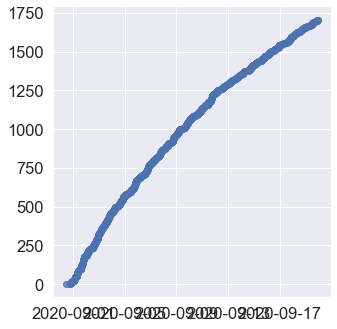

In [112]:
sns.set_style(style='darkgrid')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})

sns.lmplot(data=df, x='timestamp_reformated', y='counter')

In [134]:
content_list = [df['content'][x] for x in range(len(df['content']))]
doc = nlp(str(content_list))

dftxt = pd.DataFrame([token.lemma_ for token in doc 
                      if token.is_alpha and not token.is_stop], columns=['text'])
dftxt.head()

,text
0,create
1,GitHub
2,repo
3,create
4,R


In [135]:
dftxt.shape

(20820, 1)

In [141]:
dftxt.value_counts().head(30)

text    
day         1215
course       475
learn        331
datum        306
start        281
Data         277
Python       235
complete     227
Kaggle       198
work         186
project      177
today        164
level        158
finish       146
advance      144
GG           139
read         131
python       124
basic        120
go           116
kaggle       116
Learning     112
data         109
chapter      104
micro         94
ML            92
Day           89
watch         89
Machine       89
Pandas        88
dtype: int64

In [143]:
content_list = [df['content'][x] for x in range(len(df['content']))]
doc = nlp(str(content_list))

dfnc = pd.DataFrame([chunk.text for chunk in doc.noun_chunks], columns=['text'])
dfnc.value_counts().head(30)

text            
I                   755
it                  267
you                 258
Day                 253
Python              108
me                   74
Kaggle               69
data                 61
pandas               55
It                   55
i                    49
level                44
kaggle               44
SQL                  41
python               41
what                 40
Machine Learning     38
Pandas               37
Data Science         34
Hands                33
#66daysofdata        29
we                   29
ML                   29
DataCamp             29
day                  28
them                 27
R                    25
a lot                21
🙂                    21
the course           21
dtype: int64

In [147]:
dfnc[dfnc['text'].str.startswith('day')]

,text
116,day
308,day
453,day
491,day1
495,day
902,day
1573,day
1601,day
1860,day
1956,day3
